In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 2.0MB/s  eta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 23.7MB/s ta 0:00:01
    100% |████████████████████████████████| 10.4MB 5.2MB/s  eta 0:00:01
    100% |████████████████████████████████| 7.3MB 7.5MB/s  eta 0:00:01
    100% |████████████████████████████████| 194kB 68.0MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 52.2MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 61kB 47.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1f/fd/3a/f29866dc23dada18f25e9837477c82bbd7952aeef86fa46f11
Successfully built ujson holidays
  Found existing installation: python-dateut

In [3]:
import gluonts
gluonts.__version__

'0.4.2'

In [4]:
import mxnet
mxnet.__version__

'1.4.1'

In [5]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [6]:
dataname = "m4_hourly"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_hourly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [8]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 414
length test dataset 414


In [9]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='H'),
 'target': array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
        397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
        806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
        407., 404., 420., 441., 471., 526., 571., 612., 635., 613., 608.,
        614., 637., 669., 683., 687., 660., 661., 632., 573., 521., 481.,
        452., 447., 425., 427., 441., 438., 472., 528., 596., 661., 708.,
        754., 781., 808., 819., 820., 801., 770., 717., 697., 655., 607.,
        552., 512., 475., 452., 436., 429., 433., 430., 472., 536., 611.,
        662., 705., 707., 718., 733., 741., 737., 710., 647., 593., 564.,
        528., 507., 466., 428., 396., 382., 371., 374., 372., 373., 406.,
        451., 480., 487., 487., 494., 505., 519., 535., 560., 570., 551.,
        541., 552., 521., 477., 426., 395., 370., 357., 349., 362., 374.,
        402., 427., 456., 500., 558., 608., 661.

## Plot Series

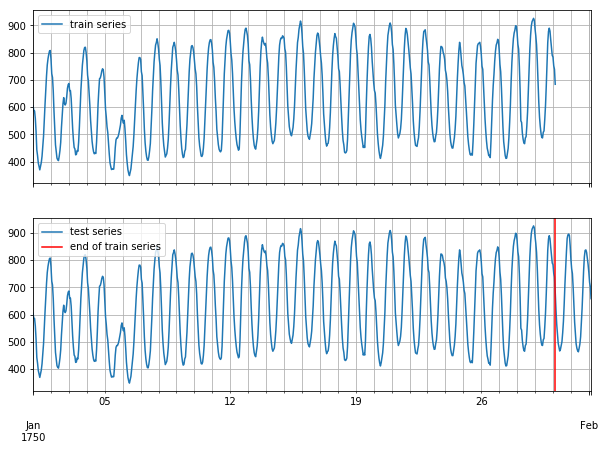

In [10]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [12]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_demographic", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 123423


Seed: 42


100%|██████████| 100/100 [00:01<00:00, 64.22it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 1.559 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.858987
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 68.78it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[1] Elapsed time 1.455 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.434935
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.87it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[2] Elapsed time 1.393 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.309105
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.25it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 1.385 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.192260
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.11it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[4] Elapsed time 1.388 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 71.50it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[37] Elapsed time 1.400 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.586058
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.53it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[38] Elapsed time 1.399 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.593798
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.64it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[39] Elapsed time 1.397 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.661765
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.91it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[40] Elapsed time 1.392 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.557171
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.13it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[41] Elapsed time 1.388 second

100%|██████████| 100/100 [00:01<00:00, 72.88it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[74] Elapsed time 1.374 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.401874
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.90it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[75] Elapsed time 1.392 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.496066
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.67it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[76] Elapsed time 1.396 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.466526
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 72.08it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[77] Elapsed time 1.389 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.403241
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 71.88it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[78] Elapsed time 1.392 seconds
I

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 72.50it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[111] Elapsed time 1.381 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.489765
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 71.79it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[112] Elapsed time 1.394 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.401602
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 72.43it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[113] Elapsed time 1.382 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.352753
INFO:root:Loading parameters from best epoch (103)
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:01<00:00, 71.22it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[114] Elapsed time 1.406 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.363934
INFO:root:Epoch[115] Learning rate is 0.00025
100

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.345288
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 70.79it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[147] Elapsed time 1.414 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.456684
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 71.82it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[148] Elapsed time 1.393 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.268958
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 72.19it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[149] Elapsed time 1.387 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.256298
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 72.50it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[150] Elapsed time 1.380 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.376052
INFO:root:Epoch[151] Learning r

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.58it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[183] Elapsed time 1.398 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.302776
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 72.04it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[184] Elapsed time 1.390 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.275651
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.51it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[185] Elapsed time 1.400 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.308461
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.54it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[186] Elapsed time 1.399 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.458512
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 71.31it/s, avg_epoch_l

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.27821  0.102706  13.078151            0.111033             0.05753    42   

   epochs  num_batches  
0     200          100  
Seed: 43


100%|██████████| 100/100 [00:01<00:00, 55.07it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[0] Elapsed time 1.817 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.806037
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.77it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[1] Elapsed time 1.733 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.383082
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.35it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[2] Elapsed time 1.745 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.252924
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.96it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[3] Elapsed time 1.757 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.160335
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 57.32it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[4] Elapsed time 1.746 seconds
INFO:root:E

100%|██████████| 100/100 [00:01<00:00, 61.69it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[37] Elapsed time 1.622 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.512174
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 60.63it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[38] Elapsed time 1.651 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.621137
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 54.64it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[39] Elapsed time 1.832 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.554406
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 61.24it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[40] Elapsed time 1.635 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.492741
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 62.25it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 1.608 second

100%|██████████| 100/100 [00:01<00:00, 55.23it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[74] Elapsed time 1.812 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.543174
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 56.51it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[75] Elapsed time 1.771 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.520572
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 53.67it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[76] Elapsed time 1.865 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.383810
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.66it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[77] Elapsed time 1.901 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.373451
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 55.35it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[78] Elapsed time 1.808 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.37it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[111] Elapsed time 1.841 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.265008
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 59.83it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[112] Elapsed time 1.673 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.309745
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 54.64it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[113] Elapsed time 1.833 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.377006
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 55.42it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[114] Elapsed time 1.807 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.375615
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:01<00:00, 56.59it/s, avg_e

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.97it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[147] Elapsed time 1.821 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.265309
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 55.35it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[148] Elapsed time 1.808 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.236330
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 54.15it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[149] Elapsed time 1.848 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.336368
INFO:root:Loading parameters from best epoch (119)
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 55.26it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[150] Elapsed time 1.811 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.357313
INFO:root:Epoch[151] Learning rate is 6.2

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.37it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[183] Elapsed time 2.069 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.254282
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.66it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[184] Elapsed time 2.103 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.283937
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.45it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 2.066 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.432681
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.64it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[186] Elapsed time 2.101 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.212039
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.42it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.291093  0.102665  12.682833            0.112623             0.05837   

   seed  epochs  num_batches  
0    43     200          100  
Seed: 44


100%|██████████| 100/100 [00:02<00:00, 46.84it/s, avg_epoch_loss=7.76]
INFO:root:Epoch[0] Elapsed time 2.137 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.756476
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.44it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[1] Elapsed time 2.110 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.411694
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.54it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 2.105 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.263435
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.93it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[3] Elapsed time 2.132 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.159829
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.26it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[4] Elapsed time 2.118 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 47.82it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[37] Elapsed time 2.095 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.536757
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.14it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 2.037 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.609679
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.33it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 2.115 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.638014
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.85it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[40] Elapsed time 2.138 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.479183
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.25it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[41] Elapsed time 2.118 second

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 48.39it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[74] Elapsed time 2.068 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.501348
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 48.73it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[75] Elapsed time 2.054 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.468606
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.85it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[76] Elapsed time 2.092 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.427889
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.01it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[77] Elapsed time 2.129 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.423397
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.95it/s, avg_epoch_loss

100%|██████████| 100/100 [00:02<00:00, 47.47it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[110] Elapsed time 2.110 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.422384
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 47.23it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[111] Elapsed time 2.121 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.555268
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 47.57it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[112] Elapsed time 2.104 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.417235
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 47.46it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[113] Elapsed time 2.109 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.407595
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 48.77it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:02<00:00, 47.67it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[146] Elapsed time 2.100 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.440591
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.07it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[147] Elapsed time 2.082 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.548461
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.31it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[148] Elapsed time 2.116 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.401513
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.07it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[149] Elapsed time 2.128 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.344767
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.35it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.66it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[183] Elapsed time 2.146 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.530248
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.71it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[184] Elapsed time 2.143 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.420671
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.54it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[185] Elapsed time 2.198 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.352902
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.45it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[186] Elapsed time 2.202 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.479926
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.44it/s, avg_epoch_

In [20]:
results = pd.DataFrame()

for i in range(45, 47):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_demographic", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_demographic.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 123423


Seed: 45


100%|██████████| 200/200 [00:03<00:00, 57.53it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[0] Elapsed time 3.478 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.594477
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.31it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 3.553 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.209145
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.08it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[2] Elapsed time 3.276 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.990934
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 56.39it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[3] Elapsed time 3.548 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.980768
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.06it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[4] Elapsed time 3.634 seconds
INFO:root:E

100%|██████████| 200/200 [00:03<00:00, 50.70it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[74] Elapsed time 3.946 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.359316
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.06it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[75] Elapsed time 3.277 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.347584
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.60it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[76] Elapsed time 3.358 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.329706
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 59.16it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[77] Elapsed time 3.385 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.322044
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.83it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[78] Elapsed time 3.649 second

100%|██████████| 200/200 [00:03<00:00, 59.07it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[111] Elapsed time 3.387 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.301203
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 54.43it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[112] Elapsed time 3.676 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.235352
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 53.38it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[113] Elapsed time 3.748 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.311971
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 55.90it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[114] Elapsed time 3.580 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.197903
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 60.61it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[115] Elapsed time 3

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 55.42it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[183] Elapsed time 3.610 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.127151
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 61.32it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[184] Elapsed time 3.263 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.161913
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 58.93it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[185] Elapsed time 3.396 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.230101
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 54.88it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[186] Elapsed time 3.646 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.092707
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 56.14i

100%|██████████| 200/200 [00:03<00:00, 56.60it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[219] Elapsed time 3.535 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.222787
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.31it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[220] Elapsed time 3.618 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.099654
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.15it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[221] Elapsed time 3.501 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.230214
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.56it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[222] Elapsed time 3.304 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.136903
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.73it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[223] Elapsed time 

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.86it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[256] Elapsed time 3.934 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.149738
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.62it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[257] Elapsed time 3.663 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.209733
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.88it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[258] Elapsed time 3.518 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.072908
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.99it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[259] Elapsed time 3.511 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.178678
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.91it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.093808
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.10it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[293] Elapsed time 2.854 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.202214
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.82it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[294] Elapsed time 2.866 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.085532
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.77it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[295] Elapsed time 2.910 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.151294
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.69it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[296] Elapsed time 2.871 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.143363
INFO:root:Epoch[297] Learning rate is 5e-05


INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.00it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[366] Elapsed time 2.859 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.177503
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.50it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[367] Elapsed time 2.879 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.088617
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.75it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[368] Elapsed time 2.869 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.222183
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.27it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[369] Elapsed time 2.888 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.097972
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.06it/s, avg_epoch_l

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.269541  0.10319  12.768553            0.109867            0.057531    45   

   epochs  num_batches  
0     400          200  
Seed: 46


100%|██████████| 200/200 [00:02<00:00, 69.61it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[0] Elapsed time 2.874 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.529683
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.16it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[1] Elapsed time 2.852 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.228249
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.65it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[2] Elapsed time 2.832 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.040903
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.18it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[3] Elapsed time 2.851 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.969331
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.62it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[4] Elapsed time 2.874 seconds
INFO:root:E

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.02it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[74] Elapsed time 2.858 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.357428
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 69.63it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[75] Elapsed time 2.874 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.349131
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 70.07it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[76] Elapsed time 2.856 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.373731
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 69.83it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[77] Elapsed time 2.867 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.320723
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 200/200 [00:02<00:00, 69.37it/s, avg_epoch_los

100%|██████████| 200/200 [00:02<00:00, 69.60it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[110] Elapsed time 2.875 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.323638
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 68.46it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[111] Elapsed time 2.923 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.257030
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 67.87it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[112] Elapsed time 2.948 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.386774
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 69.39it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[113] Elapsed time 2.884 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.288108
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:02<00:00, 69.49it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[114] 

KeyboardInterrupt: 

In [21]:
results

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.269541,0.10319,12.768553,0.109867,0.057531,45,400,200


In [ ]:
results = pd.DataFrame()

for i in range(46, 47):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_demographic", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_finance", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

In [17]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_macro", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 296273


Seed: 42


100%|██████████| 200/200 [00:05<00:00, 33.77it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[0] Elapsed time 5.934 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.653442
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 33.02it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[1] Elapsed time 6.058 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.287897
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.09it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[2] Elapsed time 5.703 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.059384
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.56it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[3] Elapsed time 5.628 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.924374
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.39it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[4] Elapsed time 5.659 seconds
INFO:root:E

100%|██████████| 200/200 [00:05<00:00, 33.46it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[74] Elapsed time 5.983 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.190988
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 34.07it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[75] Elapsed time 5.872 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.258641
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.89it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[76] Elapsed time 6.089 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.249325
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 33.36it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[77] Elapsed time 6.000 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.290895
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 34.05it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[78] Elapsed time 5.889 second

100%|██████████| 200/200 [00:06<00:00, 32.94it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[111] Elapsed time 6.074 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.195924
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.29it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[112] Elapsed time 6.199 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.104179
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 31.99it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[113] Elapsed time 6.256 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.072797
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.29it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[114] Elapsed time 6.199 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.173939
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.51it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[115] Elapsed time 5

100%|██████████| 200/200 [00:06<00:00, 32.03it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[183] Elapsed time 6.249 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.072573
INFO:root:Epoch[184] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 35.36it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[184] Elapsed time 5.662 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.107274
INFO:root:Epoch[185] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 37.70it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[185] Elapsed time 5.313 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.989634
INFO:root:Epoch[186] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 36.86it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[186] Elapsed time 5.432 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.005836
INFO:root:Epoch[187] Learning rate is 0.000125
100%|██████████| 200/200 [00:05<00:00, 34.96it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[187] 

100%|██████████| 200/200 [00:06<00:00, 32.95it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[219] Elapsed time 6.072 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.063794
INFO:root:Epoch[220] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:06<00:00, 29.85it/s, avg_epoch_loss=6]
INFO:root:Epoch[220] Elapsed time 6.705 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.996643
INFO:root:Epoch[221] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 36.90it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[221] Elapsed time 5.425 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.020448
INFO:root:Epoch[222] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 36.81it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[222] Elapsed time 5.439 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.040959
INFO:root:Epoch[223] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 38.92it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[223] Elap

INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.07it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[292] Elapsed time 5.708 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.028581
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 33.02it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[293] Elapsed time 6.063 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.991938
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 30.65it/s, avg_epoch_loss=6]
INFO:root:Epoch[294] Elapsed time 6.529 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.002362
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 31.70it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[295] Elapsed time 6.316 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.068265
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 31.71it/s, avg_epoch_los

INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=5.980835
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 35.96it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[329] Elapsed time 5.570 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.060896
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:06<00:00, 32.84it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[330] Elapsed time 6.096 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.106360
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 34.78it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[331] Elapsed time 5.757 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.985412
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 33.61it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[332] Elapsed time 5.957 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.974503
INFO:root:Epoch[333] Learning rate is 5e-05

  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 296273


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.147169  0.094925  11.198675            0.084425            0.044766   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:05<00:00, 34.10it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[0] Elapsed time 5.868 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.775587
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.82it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[1] Elapsed time 6.098 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.274502
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 32.68it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 6.124 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.106234
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 33.52it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[3] Elapsed time 5.973 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.956592
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 35.13it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[4] Elapsed time 5.701 seconds
INFO:root:E

100%|██████████| 200/200 [00:06<00:00, 32.64it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[74] Elapsed time 6.133 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.182310
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 31.77it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[75] Elapsed time 6.304 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.175789
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 34.55it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[76] Elapsed time 5.796 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.222005
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 34.99it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[77] Elapsed time 5.723 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.235118
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:06<00:00, 29.55it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[78] Elapsed time 6.776 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 31.74it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[111] Elapsed time 6.312 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.157824
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 34.51it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[112] Elapsed time 5.800 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.161724
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:05<00:00, 37.12it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[113] Elapsed time 5.390 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.134703
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 32.88it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[114] Elapsed time 6.088 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.070279
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:06<00:00, 32.56it/s, avg_e

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.128601
INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 39.96it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[183] Elapsed time 5.010 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.034600
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:05<00:00, 38.31it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[184] Elapsed time 5.223 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.009153
INFO:root:Loading parameters from best epoch (154)
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.92it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[185] Elapsed time 5.017 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.080853
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 40.82it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[186] Elapsed time 4.904 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_l

100%|██████████| 200/200 [00:05<00:00, 37.38it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[219] Elapsed time 5.355 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.075733
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.03it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[220] Elapsed time 5.131 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.097773
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.15it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[221] Elapsed time 5.248 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.119567
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.99it/s, avg_epoch_loss=6]
INFO:root:Epoch[222] Elapsed time 5.134 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.001478
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.15it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[223] Elapsed time 5.5

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.43it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[256] Elapsed time 5.218 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.018055
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 38.35it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[257] Elapsed time 5.219 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.025982
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.18it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[258] Elapsed time 5.109 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.042300
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.10it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[259] Elapsed time 5.393 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.081750
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 36.78it/s, avg_epoch_

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.046419
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.55it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[293] Elapsed time 5.327 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.099961
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.88it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[294] Elapsed time 5.283 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.093299
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.68it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[295] Elapsed time 5.313 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.008085
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 37.73it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[296] Elapsed time 5.304 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.026781
INFO:root:Epoch[297] Learning rate is 5e-05


INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:05<00:00, 39.68it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[366] Elapsed time 5.042 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.064317
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.04it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[367] Elapsed time 4.762 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.077929
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.96it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[368] Elapsed time 4.660 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.992017
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 42.00it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[369] Elapsed time 4.768 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.012294
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 41.80it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.188485  0.096739  11.616688            0.085815            0.045578   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:05<00:00, 36.39it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[0] Elapsed time 5.500 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.740218
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.36it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[1] Elapsed time 5.361 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.282449
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.12it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 5.253 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.145120
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 37.37it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[3] Elapsed time 5.358 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.043812
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:05<00:00, 38.77it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[4] Elapsed time 5.162 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 46.55it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[74] Elapsed time 4.300 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.277762
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.81it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[75] Elapsed time 4.275 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.187083
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.34it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[76] Elapsed time 4.318 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.157632
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.87it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[77] Elapsed time 4.362 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.190311
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.53it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[78] Elapsed time 4.299 second

INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.29it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[111] Elapsed time 4.322 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.184159
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 45.97it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[112] Elapsed time 4.352 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.171805
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.35it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[113] Elapsed time 4.317 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.135640
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.93it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[114] Elapsed time 4.266 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.065007
INFO:root:Epoch[115] Learning rate is 0.00025

INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 46.50it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[147] Elapsed time 4.303 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.164674
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.56it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[148] Elapsed time 4.120 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.026912
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.01it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[149] Elapsed time 4.168 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.015218
INFO:root:Epoch[150] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 46.57it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[150] Elapsed time 4.296 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.115828
INFO:root:Epoch[151] Learning rate is 0.000125
100%|██████████| 200/200 [00:04<00:00, 48.35i

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47.38it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[183] Elapsed time 4.223 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.029907
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 46.31it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[184] Elapsed time 4.320 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.022903
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 46.62it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[185] Elapsed time 4.292 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.068274
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47.09it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[186] Elapsed time 4.249 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.112491
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47.56i

100%|██████████| 200/200 [00:04<00:00, 46.58it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[219] Elapsed time 4.298 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.044340
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.87it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[220] Elapsed time 4.179 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.071028
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.76it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[221] Elapsed time 4.278 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.123192
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.97it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[222] Elapsed time 4.262 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.035860
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.37it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[223] Elapsed time

INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.48it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[256] Elapsed time 4.214 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.067788
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.48it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[257] Elapsed time 4.305 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.983252
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.91it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[258] Elapsed time 4.265 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.043435
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.44it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[259] Elapsed time 4.308 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.098034
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.36it/s, avg_epoch_l

INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=6.011356
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.53it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[293] Elapsed time 4.300 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.055603
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.81it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[294] Elapsed time 4.369 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.071962
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.04it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[295] Elapsed time 4.254 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.122458
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.87it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[296] Elapsed time 4.272 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.026114
INFO:root:Epoch[297] Learning rate is 5e-05

INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.35it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[366] Elapsed time 4.225 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.974353
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.99it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[367] Elapsed time 4.352 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.977472
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.60it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[368] Elapsed time 4.293 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.074145
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.88it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[369] Elapsed time 4.268 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.125552
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.39it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.153386  0.095779  11.357948            0.085405            0.044206   

   seed  epochs  num_batches  
0    44     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.147169,0.094925,11.198675,0.084425,0.044766,42,400,200
0,1.188485,0.096739,11.616688,0.085815,0.045578,43,400,200
0,1.153386,0.095779,11.357948,0.085405,0.044206,44,400,200


In [18]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_micro", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 331523


Seed: 42


100%|██████████| 200/200 [00:04<00:00, 46.38it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[0] Elapsed time 4.314 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.619911
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.63it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[1] Elapsed time 4.291 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.136472
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.27it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[2] Elapsed time 4.324 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.990287
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 45.90it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 4.360 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.827830
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.80it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[4] Elapsed time 4.276 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 46.63it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[74] Elapsed time 4.291 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.224693
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.74it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[75] Elapsed time 4.281 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.249888
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.71it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[76] Elapsed time 4.284 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.207275
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.01it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[77] Elapsed time 4.256 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.194593
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.15it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[78] Elapsed time 4.335 second

INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 43.55it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[111] Elapsed time 4.595 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.137261
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 44.75it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[112] Elapsed time 4.474 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.108947
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 47.27it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[113] Elapsed time 4.236 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.089676
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.57it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[114] Elapsed time 4.296 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.209766
INFO:root:Epoch[115] Learning rate is 0.00025

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.082594
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 46.38it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[147] Elapsed time 4.314 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.119460
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47.07it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[148] Elapsed time 4.251 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.092384
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 46.19it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[149] Elapsed time 4.332 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.095891
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 43.66it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[150] Elapsed time 4.583 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.114262
INFO:root:Epoch[151] Learning ra

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.67it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[183] Elapsed time 4.288 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.133490
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.21it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[184] Elapsed time 4.238 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.119367
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.36it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[185] Elapsed time 4.225 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.130412
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.69it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[186] Elapsed time 4.287 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.091650
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.83it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.065355
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.90it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[220] Elapsed time 4.266 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.091173
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.30it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[221] Elapsed time 4.230 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.148391
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.46it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[222] Elapsed time 4.307 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.119918
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.38it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[223] Elapsed time 4.314 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.080703
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.50it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[293] Elapsed time 4.303 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.107205
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.69it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[294] Elapsed time 4.286 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.086001
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.18it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[295] Elapsed time 4.333 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.095489
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.50it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[296] Elapsed time 4.302 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.091225
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.31it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.087598
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.09it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[330] Elapsed time 4.341 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.055977
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.15it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[331] Elapsed time 4.337 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.098514
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.73it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[332] Elapsed time 4.281 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.053708
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.15it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[333] Elapsed time 4.243 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.044194
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.160183  0.103238  12.540534             0.09705             0.05336   

   seed  epochs  num_batches  
0    42     400          200  
Seed: 43


100%|██████████| 200/200 [00:04<00:00, 47.73it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[0] Elapsed time 4.192 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.593924
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.39it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[1] Elapsed time 4.313 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.089819
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.56it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[2] Elapsed time 4.207 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.990698
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.90it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 4.094 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.833957
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.13it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[4] Elapsed time 4.158 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 46.99it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[74] Elapsed time 4.260 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.182151
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.90it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[75] Elapsed time 4.268 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.242549
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.37it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[76] Elapsed time 4.224 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.196721
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.48it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[77] Elapsed time 4.305 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.203273
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 46.57it/s, avg_epoch_loss=6.

100%|██████████| 200/200 [00:04<00:00, 45.65it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[146] Elapsed time 4.383 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.154695
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.36it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[147] Elapsed time 4.316 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.127978
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.82it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[148] Elapsed time 4.275 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.142928
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.84it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[149] Elapsed time 4.272 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.088110
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.49it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.03it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[183] Elapsed time 4.165 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.069859
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.46it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[184] Elapsed time 4.307 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.055322
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.39it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[185] Elapsed time 4.223 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.130288
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 48.38it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[186] Elapsed time 4.136 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.139202
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.86it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.131961
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.60it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[220] Elapsed time 4.295 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.093153
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.86it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[221] Elapsed time 4.269 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.103898
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.20it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[222] Elapsed time 4.240 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.120708
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.67it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[223] Elapsed time 4.287 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.117275
INFO:root:Epoch[224] Learning rate is 5e-05


INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.11it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[293] Elapsed time 4.247 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.088643
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.23it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[294] Elapsed time 4.330 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.086470
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.50it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[295] Elapsed time 4.305 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.079876
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.99it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[296] Elapsed time 4.258 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.051311
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.10it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.074672
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.60it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[330] Elapsed time 4.294 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.076074
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.95it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[331] Elapsed time 4.261 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.110060
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.46it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[332] Elapsed time 4.310 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.087880
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.43it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[333] Elapsed time 4.310 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.121204
INFO:root:Epoch[334] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.169405  0.103026  12.708055            0.096804            0.053735   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:04<00:00, 47.29it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[0] Elapsed time 4.231 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.654500
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.30it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[1] Elapsed time 4.142 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.210212
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.32it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 4.229 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.078705
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 47.09it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[3] Elapsed time 4.249 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.922527
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 46.57it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[4] Elapsed time 4.296 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 46.67it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[74] Elapsed time 4.288 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.207881
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 47.33it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[75] Elapsed time 4.227 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.210947
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 46.74it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[76] Elapsed time 4.281 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.221742
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 46.93it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[77] Elapsed time 4.264 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.199551
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 46.11it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[78] Elapsed time 4.340 sec

INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.71it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[111] Elapsed time 4.284 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.151949
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 47.16it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[112] Elapsed time 4.242 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.195965
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.54it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[113] Elapsed time 4.299 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.118956
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 47.36it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[114] Elapsed time 4.224 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=6.099011
INFO:root:Epoch[115] Learning rate is 0.00025
100%|██████████| 200/200 [00:04<00:00, 46.10it/s, av

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.094074
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 46.84it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[147] Elapsed time 4.271 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.102149
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 47.79it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[148] Elapsed time 4.186 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.086486
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 45.09it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[149] Elapsed time 4.437 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.084265
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 46.56it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[150] Elapsed time 4.297 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.138807
INFO:root:Epoch[151] Learning ra

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.66it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[183] Elapsed time 4.289 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.137232
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.70it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[184] Elapsed time 4.287 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.135248
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.28it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[185] Elapsed time 4.232 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.125929
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 45.92it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[186] Elapsed time 4.357 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.149649
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.12it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.142479
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.59it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[220] Elapsed time 4.295 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.157497
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.25it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[221] Elapsed time 4.235 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.100299
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.54it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[222] Elapsed time 4.212 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.156832
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.51it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[223] Elapsed time 4.305 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.105016
INFO:root:Epoch[224] Learning rate is 5e-05


INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.70it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[293] Elapsed time 4.285 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=6.107830
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.27it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[294] Elapsed time 4.324 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.043256
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.49it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[295] Elapsed time 4.303 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.069479
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.20it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[296] Elapsed time 4.330 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=6.104017
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.60it/s, avg_epoch_l

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=6.117695
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.49it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[330] Elapsed time 4.304 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.101574
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 46.28it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[331] Elapsed time 4.323 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.107775
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.07it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[332] Elapsed time 4.251 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.092109
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 47.31it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[333] Elapsed time 4.229 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.120728
INFO:root:Epoch[334] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.176764  0.103968  12.475932            0.097538            0.053679   

   seed  epochs  num_batches  
0    44     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.160183,0.103238,12.540534,0.097050,0.053360,42,400,200
0,1.169405,0.103026,12.708055,0.096804,0.053735,43,400,200
0,1.176764,0.103968,12.475932,0.097538,0.053679,44,400,200


In [ ]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_other", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

In [19]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = deepar(data="m4_quarterly_other", seed=i, epochs=400, batches=200)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_quarterly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 73773


Seed: 42


100%|██████████| 200/200 [00:04<00:00, 48.16it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[0] Elapsed time 4.154 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.566609
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 50.26it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[1] Elapsed time 3.981 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.146783
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.42it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[2] Elapsed time 4.048 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.936927
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.41it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[3] Elapsed time 4.049 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.791077
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.48it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[4] Elapsed time 4.127 seconds
INFO:root:E

100%|██████████| 200/200 [00:04<00:00, 48.10it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[74] Elapsed time 4.162 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.035704
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.75it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[75] Elapsed time 4.106 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.969940
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.59it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[76] Elapsed time 4.035 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.022174
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 48.52it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[77] Elapsed time 4.123 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.963579
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:04<00:00, 49.10it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[78] Elapsed time 4.075 second

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 48.48it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[111] Elapsed time 4.131 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.837672
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 47.61it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[112] Elapsed time 4.203 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.816639
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 49.17it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[113] Elapsed time 4.069 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.887139
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 48.18it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[114] Elapsed time 4.153 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.809903
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 49.01it/s, avg_e

INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.741661
INFO:root:Epoch[184] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 59.74it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[184] Elapsed time 3.350 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.743981
INFO:root:Epoch[185] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 60.02it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[185] Elapsed time 3.334 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.767300
INFO:root:Epoch[186] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 54.86it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[186] Elapsed time 3.647 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.722578
INFO:root:Epoch[187] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 53.61it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[187] Elapsed time 3.733 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=5.740002
INFO:root:Epoch[188] Learning rate is 0

100%|██████████| 200/200 [00:02<00:00, 70.73it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[255] Elapsed time 2.829 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.666812
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.45it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[256] Elapsed time 2.840 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.618233
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.04it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[257] Elapsed time 2.898 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.693383
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.18it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[258] Elapsed time 2.811 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.679838
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.36it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[259] Elapsed time

INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.96it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[292] Elapsed time 2.860 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=5.623637
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.33it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[293] Elapsed time 2.805 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.668238
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.97it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[294] Elapsed time 2.860 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.668015
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 71.55it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[295] Elapsed time 2.796 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.627434
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.54it/s, avg_epoch_

INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=5.602892
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.84it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[329] Elapsed time 2.865 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.603997
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.49it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[330] Elapsed time 2.839 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.630408
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 70.33it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[331] Elapsed time 2.845 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.618785
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 67.79it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[332] Elapsed time 2.953 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.639574
INFO:root:Epoch[333] Learning rate is 5e-05


  0%|          | 0/200 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 73773


       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  0.924432  0.070516  9.948232            0.062457            0.032639    42   

   epochs  num_batches  
0     400          200  
Seed: 43


100%|██████████| 200/200 [00:02<00:00, 69.51it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 2.879 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.701646
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.90it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[1] Elapsed time 2.822 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.182160
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.68it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[2] Elapsed time 3.093 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.945661
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.31it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[3] Elapsed time 3.111 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.786156
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.62it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[4] Elapsed time 3.096 seconds
INFO:root:Ep

100%|██████████| 200/200 [00:03<00:00, 63.77it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[74] Elapsed time 3.138 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.914783
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 63.62it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[75] Elapsed time 3.145 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.927445
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 64.23it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[76] Elapsed time 3.115 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.936155
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 67.07it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[77] Elapsed time 2.983 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.980331
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.20it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[78] Elapsed time 2.850 second

100%|██████████| 200/200 [00:02<00:00, 69.11it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[111] Elapsed time 2.895 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.841211
INFO:root:Epoch[112] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.64it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[112] Elapsed time 2.832 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.863033
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.42it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[113] Elapsed time 2.882 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.801095
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.21it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[114] Elapsed time 2.891 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.825174
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.71it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[115] Elapsed time 

INFO:root:Epoch[148] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.30it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[148] Elapsed time 2.846 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.755252
INFO:root:Epoch[149] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.76it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[149] Elapsed time 2.868 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.813815
INFO:root:Epoch[150] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.68it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[150] Elapsed time 2.872 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.757336
INFO:root:Epoch[151] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.62it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[151] Elapsed time 2.834 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=5.759245
INFO:root:Epoch[152] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.24it/s, avg_epoch_

INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.736177
INFO:root:Epoch[185] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 68.99it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[185] Elapsed time 2.901 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.729114
INFO:root:Epoch[186] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.26it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[186] Elapsed time 2.889 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.740271
INFO:root:Epoch[187] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 70.06it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[187] Elapsed time 2.856 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=5.735369
INFO:root:Epoch[188] Learning rate is 0.001
100%|██████████| 200/200 [00:02<00:00, 69.88it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[188] Elapsed time 2.863 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=5.746840
INFO:root:Epoch[189] Learning rate is 0.001

100%|██████████| 200/200 [00:02<00:00, 68.84it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[221] Elapsed time 2.907 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.661362
INFO:root:Epoch[222] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 67.83it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[222] Elapsed time 2.950 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.647188
INFO:root:Epoch[223] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 68.78it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[223] Elapsed time 2.909 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=5.640492
INFO:root:Epoch[224] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 68.42it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[224] Elapsed time 2.925 seconds
INFO:root:Epoch[224] Evaluation metric 'epoch_loss'=5.650242
INFO:root:Epoch[225] Learning rate is 0.0005
100%|██████████| 200/200 [00:02<00:00, 70.15it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[225] Elapsed 

100%|██████████| 200/200 [00:03<00:00, 62.33it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[257] Elapsed time 3.210 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.574002
INFO:root:Epoch[258] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 63.57it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[258] Elapsed time 3.147 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.577501
INFO:root:Epoch[259] Learning rate is 0.000125
100%|██████████| 200/200 [00:03<00:00, 63.06it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[259] Elapsed time 3.173 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.522024
INFO:root:Epoch[260] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 69.14it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[260] Elapsed time 2.894 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=5.584402
INFO:root:Epoch[261] Learning rate is 0.000125
100%|██████████| 200/200 [00:02<00:00, 69.74it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[261] 

100%|██████████| 200/200 [00:02<00:00, 69.96it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[293] Elapsed time 2.861 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=5.548072
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.94it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[294] Elapsed time 2.861 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=5.574006
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.70it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[295] Elapsed time 2.913 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=5.505202
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.29it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[296] Elapsed time 2.930 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=5.527245
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.01it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[297] Elapsed time

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.58it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[330] Elapsed time 2.876 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.551991
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.23it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[331] Elapsed time 2.890 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.541405
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.97it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[332] Elapsed time 2.860 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.490443
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 68.74it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[333] Elapsed time 2.911 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.548169
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 200/200 [00:02<00:00, 69.17it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.530525
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.47it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[367] Elapsed time 3.422 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.544748
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.86it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[368] Elapsed time 3.582 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.496219
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.34it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[369] Elapsed time 3.430 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.518512
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.98it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[370] Elapsed time 3.575 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=5.517090
INFO:root:Epoch[371] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  0.936148  0.072016  10.045345            0.064279            0.034433   

   seed  epochs  num_batches  
0    43     400          200  
Seed: 44


100%|██████████| 200/200 [00:03<00:00, 60.89it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[0] Elapsed time 3.287 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.568503
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.25it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[1] Elapsed time 3.267 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.146182
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 57.20it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[2] Elapsed time 3.499 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.913389
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 53.55it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 3.736 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.832248
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 200/200 [00:03<00:00, 61.86it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[4] Elapsed time 3.235 seconds
INFO:root:E

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 51.06it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[74] Elapsed time 3.919 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.907328
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 50.95it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[75] Elapsed time 3.927 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.954191
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 200/200 [00:04<00:00, 49.64it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[76] Elapsed time 4.031 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.900368
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 52.74it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[77] Elapsed time 3.793 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.954585
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 200/200 [00:03<00:00, 50.24it/s, avg_epoch_loss=5.89

INFO:root:Epoch[146] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 49.68it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[146] Elapsed time 4.027 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.774011
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:04<00:00, 48.87it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[147] Elapsed time 4.094 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.800028
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 50.25it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[148] Elapsed time 3.982 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.800055
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 50.16it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[149] Elapsed time 3.990 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.768681
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 200/200 [00:03<00:00, 51.48it/

INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.95it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[219] Elapsed time 4.006 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=5.778218
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 200/200 [00:04<00:00, 49.96it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[220] Elapsed time 4.005 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=5.774964
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 52.95it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[221] Elapsed time 3.779 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=5.792489
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.76it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[222] Elapsed time 3.944 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=5.773261
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 50.32it/s, avg_epoch_

INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=5.785357
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 57.24it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[256] Elapsed time 3.496 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.774131
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.12it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[257] Elapsed time 3.697 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=5.748277
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.33it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[258] Elapsed time 3.317 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=5.809133
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.64it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[259] Elapsed time 3.299 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.742821
INFO:root:Epoch[260] Learning rate is 5e-05

INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 58.43it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[329] Elapsed time 3.424 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=5.733904
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 55.55it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[330] Elapsed time 3.602 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.758018
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.82it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[331] Elapsed time 3.650 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.734383
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 54.54it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[332] Elapsed time 3.669 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=5.739377
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 62.23it/s, avg_epoch_

INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=5.739371
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 56.24it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[366] Elapsed time 3.560 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.719377
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 60.61it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[367] Elapsed time 3.301 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.667451
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 59.24it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[368] Elapsed time 3.378 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=5.767959
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 200/200 [00:03<00:00, 53.94it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[369] Elapsed time 3.711 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.749049
INFO:root:Epoch[370] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  0.936611  0.071214  9.303355            0.063542            0.033253    44   

   epochs  num_batches  
0     400          200  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,0.924432,0.070516,9.948232,0.062457,0.032639,42,400,200
0,0.936148,0.072016,10.045345,0.064279,0.034433,43,400,200
0,0.936611,0.071214,9.303355,0.063542,0.033253,44,400,200
